In [1]:
import sys
import getpass
import requests
import fiona
import json
import os

user = getpass.getuser()
sys.dont_write_bytecode = True

# for macOS Monterey
sys.path.insert(0, '/Users/{}/Library/CloudStorage/Box-Box/Utility Code'.format(user))

from utils_io import *

# for macOS Monterey
sys.path.insert(0, '/Users/{}/Documents/GitHub/hess_application/data_processing/6 - affh'.format(user))

import census

#Geoimports
import geopandas as gp

from matplotlib import pyplot as plt

In [2]:
census_api_key = getpass.getpass()

········


In [38]:
work_dir = os.path.join(
    '/Users',
    user,
    'Library',
    'CloudStorage',
    'Box-Box',
    'DataViz Projects',
    'Spatial Analysis and Mapping',
    'I-880 Express Lane START LEP Analysis'
)

## Pull Decennial Census table variables

In [3]:
rq = requests.get('https://api.census.gov/data/2020/dec/pl/variables.json')
data = rq.json()

In [4]:
tbl_vars = pd.DataFrame.from_dict(data['variables'],orient='index')

In [5]:
tbl_vars.reset_index(inplace=True)

In [6]:
tbl_vars.rename(columns={'index':'name'},inplace=True)

In [7]:
p2_vars = [
    'P2_001N',
    'P2_002N',
    'P2_003N',
    'P2_004N',
    'P2_005N',
    'P2_006N',
    'P2_007N',
    'P2_008N',
    'P2_009N',
    'P2_010N',
    'P2_011N'
]
p2_race_vars = tbl_vars[tbl_vars['name'].isin(p2_vars)]

In [8]:
p2_race_vars.to_csv('data/decennial_census_tbl_vars_p2.csv')

## Pull Decennial Census from Census API

summarize not Hispanic/Latino by races you want, an other category, and multi-racial; then all Hispanic/Latino people in one group. That's the standard I see in most places.

In [9]:
acs_vars_lst = p2_race_vars['name'].to_list()

In [13]:
# pull race and hispanic or latino data
dc_df = census.pull_decennial_census_data(
    census_api_key=census_api_key, 
    select_table_vars=acs_vars_lst
)

In [15]:
rename_dict = {
    'P2_001N': 'total_pop',
    'P2_002N': 'hispanic_latino_pop',
    'P2_003N': 'non_hispanic_latino_pop',
    'P2_004N': 'non_hl_pop_one_race',
    'P2_005N': 'non_hl_white',
    'P2_006N': 'non_hl_black',
    'P2_007N': 'non_hl_indian_alaska_native',
    'P2_008N': 'non_hl_asian',
    'P2_009N': 'non_hl_hawaiian_pacific_islander',
    'P2_010N': 'non_hl_other_race',
    'P2_011N': 'non_hl_multi_racial'
}
dc_df.rename(columns=rename_dict,inplace=True)

In [20]:
col_order = [
    'tract_geoid',
    'fipco',
    'total_pop',
    'hispanic_latino_pop',
    'non_hl_white',
    'non_hl_black',
    'non_hl_indian_alaska_native',
    'non_hl_asian',
    'non_hl_hawaiian_pacific_islander',
    'non_hl_other_race',
    'non_hl_multi_racial'
]

In [21]:
dc_df = dc_df[col_order]

In [23]:
#Check that adding columns adds up to total pop
(
    dc_df.hispanic_latino_pop + 
    dc_df.non_hl_white + 
    dc_df.non_hl_black + 
    dc_df.non_hl_indian_alaska_native + 
    dc_df.non_hl_asian + 
    dc_df.non_hl_hawaiian_pacific_islander + 
    dc_df.non_hl_other_race + 
    dc_df.non_hl_multi_racial
)

0       4581
1       2685
2       6559
3       5879
4       3071
        ... 
1767    4983
1768    5163
1769    4123
1770    3756
1771    4151
Length: 1772, dtype: int64

In [24]:
dc_df

tract_geoid fipco  total_pop  hispanic_latino_pop  non_hl_white  \
0     06013313102   013       4581                 1548           935   
1     06013313104   013       2685                 1182           566   
2     06013313105   013       6559                 2332          1003   
3     06013313106   013       5879                 1877          1139   
4     06013313107   013       3071                 1307           842   
...           ...   ...        ...                  ...           ...   
1767  06085512309   085       4983                 1247          2682   
1768  06085512310   085       5163                 2445          1503   
1769  06085512311   085       4123                 1503          1622   
1770  06085512312   085       3756                 1222          1695   
1771  06085512313   085       4151                 2102          1326   

      non_hl_black  non_hl_indian_alaska_native  non_hl_asian  \
0             1203                           16           531   
1              377                           11           450   
2             1780                           25           952   
3             1058                           21          1311   
4              343                           14           334   
...            ...                          ...           ...   
1767            84                            8           595   
1768           160                            8           798   
1769            70                           17           679   
1770           115                            7           476   
1771           110                           12           360   

      non_hl_hawaiian_pacific_islander  non_hl_other_race  non_hl_multi_racial  
0                                   50                 43                  255  
1                                    6                  9                   84  
2                                   94                 52                  321  
3                                   58                 53                  362  
4                                   56                 28                  147  
...                                ...                ...                  ...  
1767                                 8                 35                  324  
1768                                15                 17                  217  
1769                                10                 20                  202  
1770                                32                 23                  186  
1771                                23                 24                  194  

[1772 rows x 11 columns]

## Pull American community Service Tracts Geodata

### Query Census TIGER Tracts to get Bay Area Census Tract geography

#### [Census TIGERweb REST API Documentation](https://tigerweb.geo.census.gov/tigerwebmain/TIGERweb_restmapservice.html)

In [27]:
tracts_gdf = census.pull_census_tracts_geodata(year=2020, cartographic=True)

In [28]:
tracts_gdf.explore()

## Join data to bay area tracts

In [29]:
dc_gdf = pd.merge(
    tracts_gdf,
    dc_df,
    on='tract_geoid',
    how='inner'
)

In [30]:
dc_gdf

geometry  tract_geoid fipco  \
0     POLYGON ((-122.24691 37.88535, -122.24683 37.8...  06001400100   001   
1     POLYGON ((-122.25742 37.84310, -122.25792 37.8...  06001400200   001   
2     POLYGON ((-122.26416 37.84000, -122.26563 37.8...  06001400300   001   
3     POLYGON ((-122.26181 37.84179, -122.26186 37.8...  06001400400   001   
4     POLYGON ((-122.26941 37.84811, -122.26923 37.8...  06001400500   001   
...                                                 ...          ...   ...   
1760  MULTIPOLYGON (((-123.49916 38.77833, -123.4989...  06097154304   097   
1761  POLYGON ((-123.07149 38.36443, -123.06826 38.3...  06097154305   097   
1762  POLYGON ((-123.01237 38.43284, -123.01342 38.4...  06097154306   097   
1763  POLYGON ((-123.45486 38.71002, -123.45466 38.7...  06097154307   097   
1764  POLYGON ((-123.53306 38.76842, -123.53354 38.7...  06097154308   097   

      total_pop  hispanic_latino_pop  non_hl_white  non_hl_black  \
0          3038                  205          1840           140   
1          2001                  207          1383            39   
2          5504                  547          3293           544   
3          4112                  374          2676           283   
4          3644                  437          1898           617   
...         ...                  ...           ...           ...   
1760       2181                  299          1581            10   
1761       1665                  182          1350            10   
1762       2093                  173          1735             6   
1763        745                   52           632             3   
1764        787                   95           652             1   

      non_hl_indian_alaska_native  non_hl_asian  \
0                               0           538   
1                               0           190   
2                              11           540   
3                               6           386   
4                               8           304   
...                           ...           ...   
1760                           92            39   
1761                            0            31   
1762                            3            36   
1763                            7             9   
1764                            2            12   

      non_hl_hawaiian_pacific_islander  non_hl_other_race  non_hl_multi_racial  
0                                   10                 49                  256  
1                                    2                 14                  166  
2                                   23                 37                  509  
3                                    8                 29                  350  
4                                    5                 38                  337  
...                                ...                ...                  ...  
1760                                 0                 35                  125  
1761                                 0                  8                   84  
1762                                 0                 23                  117  
1763                                 2                 12                   28  
1764                                 0                  0                   25  

[1765 rows x 12 columns]

In [32]:
dc_gdf.columns.to_list()

['geometry',
 'tract_geoid',
 'fipco',
 'total_pop',
 'hispanic_latino_pop',
 'non_hl_white',
 'non_hl_black',
 'non_hl_indian_alaska_native',
 'non_hl_asian',
 'non_hl_hawaiian_pacific_islander',
 'non_hl_other_race',
 'non_hl_multi_racial']

In [35]:
reorder_cols = [
    'tract_geoid',
    'fipco',
    'total_pop',
    'hispanic_latino_pop',
    'non_hl_white',
    'non_hl_black',
    'non_hl_indian_alaska_native',
    'non_hl_asian',
    'non_hl_hawaiian_pacific_islander',
    'non_hl_other_race',
    'non_hl_multi_racial',
    'geometry'
]

In [36]:
dc_gdf = dc_gdf[reorder_cols]

## Read 880 corridor data

In [39]:
fgdb = os.path.join(work_dir,
                    'arcgis_projects',
                    'FastTrak START Pilot Mapping',
                    'FastTrak START Pilot Mapping.gdb'
                   )

In [40]:
fiona.listlayers(fgdb)

['tomtom_2019_road_highway_interstate',
 'tomtom_2019_interstate_880',
 'interstate_880_corridor_study_area',
 'Expresslanes_880',
 'coc_study_area',
 'low_income_language_at_home_acs2014_2018',
 'low_income_language_at_home_acs2014_2018_study_area',
 'Low_Income_Tracts',
 'express_lanes_hov_pilot_680',
 'express_lanes_hov_pilot_680_study_area',
 'low_income_over5_language_at_home_acs2015_2019_I680',
 'low_income_tracts_i680_dissolve']

In [41]:
corridor_study_area = gp.read_file(fgdb,driver='FileGDB',
                                   layer='interstate_880_corridor_study_area')

In [42]:
corridor_study_area.explore()

In [43]:
#Project to wgs84
corridor_study_area.to_crs('EPSG:4326', inplace=True)

In [44]:
corridor_study_area.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Clip census tracts to study area

In [45]:
dc_clip_gdf = gp.clip(dc_gdf, corridor_study_area)

/Users/jcroff/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [46]:
dc_clip_gdf.explore()

## Summarize data

In [48]:
summary_cols = [
    'total_pop',
    'hispanic_latino_pop',
    'non_hl_white',
    'non_hl_black',
    'non_hl_indian_alaska_native',
    'non_hl_asian',
    'non_hl_hawaiian_pacific_islander',
    'non_hl_other_race',
    'non_hl_multi_racial'
]
study_area_summary = dc_clip_gdf[summary_cols].aggregate('sum').to_frame().T

In [49]:
summary_cols_pct_dict = {
 'hispanic_latino_pop': 'pct_hispanic_latino_pop',
 'non_hl_white': 'pct_non_hl_white',
 'non_hl_black': 'pct_non_hl_black',
 'non_hl_indian_alaska_native': 'pct_non_hl_indian_alaska_native',
 'non_hl_asian': 'pct_non_hl_asian',
 'non_hl_hawaiian_pacific_islander': 'pct_non_hl_hawaiian_pacific_islander',
 'non_hl_other_race': 'pct_non_hl_other_race',
 'non_hl_multi_racial': 'pct_non_hl_multi_racial'
}

In [51]:
study_area_summary = census.create_share_columns(
    df=study_area_summary, 
    universe_column='total_pop', 
    share_column_dict=summary_cols_pct_dict
)

In [52]:
study_area_summary_transpose = study_area_summary.T

In [53]:
study_area_summary_transpose.rename(columns={0:'Summary_Statistics'},inplace=True)

In [59]:
work_dir

'/Users/jcroff/Library/CloudStorage/Box-Box/DataViz Projects/Spatial Analysis and Mapping/I-880 Express Lane START LEP Analysis'

In [60]:
out_dir = os.path.join(work_dir, 'data','I880_Corridor_Population_by_Race_Origin_Summary_Census2020.csv')
study_area_summary_transpose.to_csv(out_dir)

## Graph data

In [ ]:
study_area_summary_transpose

In [55]:
graph_sum_cols = [
    'pct_hispanic_latino_pop',
    'pct_non_hl_white',
    'pct_non_hl_black',
    'pct_non_hl_indian_alaska_native',
    'pct_non_hl_asian',
    'pct_non_hl_hawaiian_pacific_islander',
    'pct_non_hl_other_race',
    'pct_non_hl_multi_racial'
]
study_area_pct = study_area_summary_transpose.loc[graph_sum_cols]

In [56]:
index_rename = {
    'pct_hispanic_latino_pop':'Hispanic or Latino',
    'pct_non_hl_white':'White',
    'pct_non_hl_black':'Black',
    'pct_non_hl_indian_alaska_native':'Native American + Alaskan',
    'pct_non_hl_asian':'Asian',
    'pct_non_hl_hawaiian_pacific_islander':'Hawaiian Pacific Islander',
    'pct_non_hl_other_race':'Other',
    'pct_non_hl_multi_racial':'Multiracial'
}
study_area_pct.rename(index=index_rename, inplace=True)

In [57]:
study_area_pct.index

Index(['Hispanic or Latino', 'White', 'Black', 'Native American + Alaskan',
       'Asian', 'Hawaiian Pacific Islander', 'Other', 'Multiracial'],
      dtype='object')

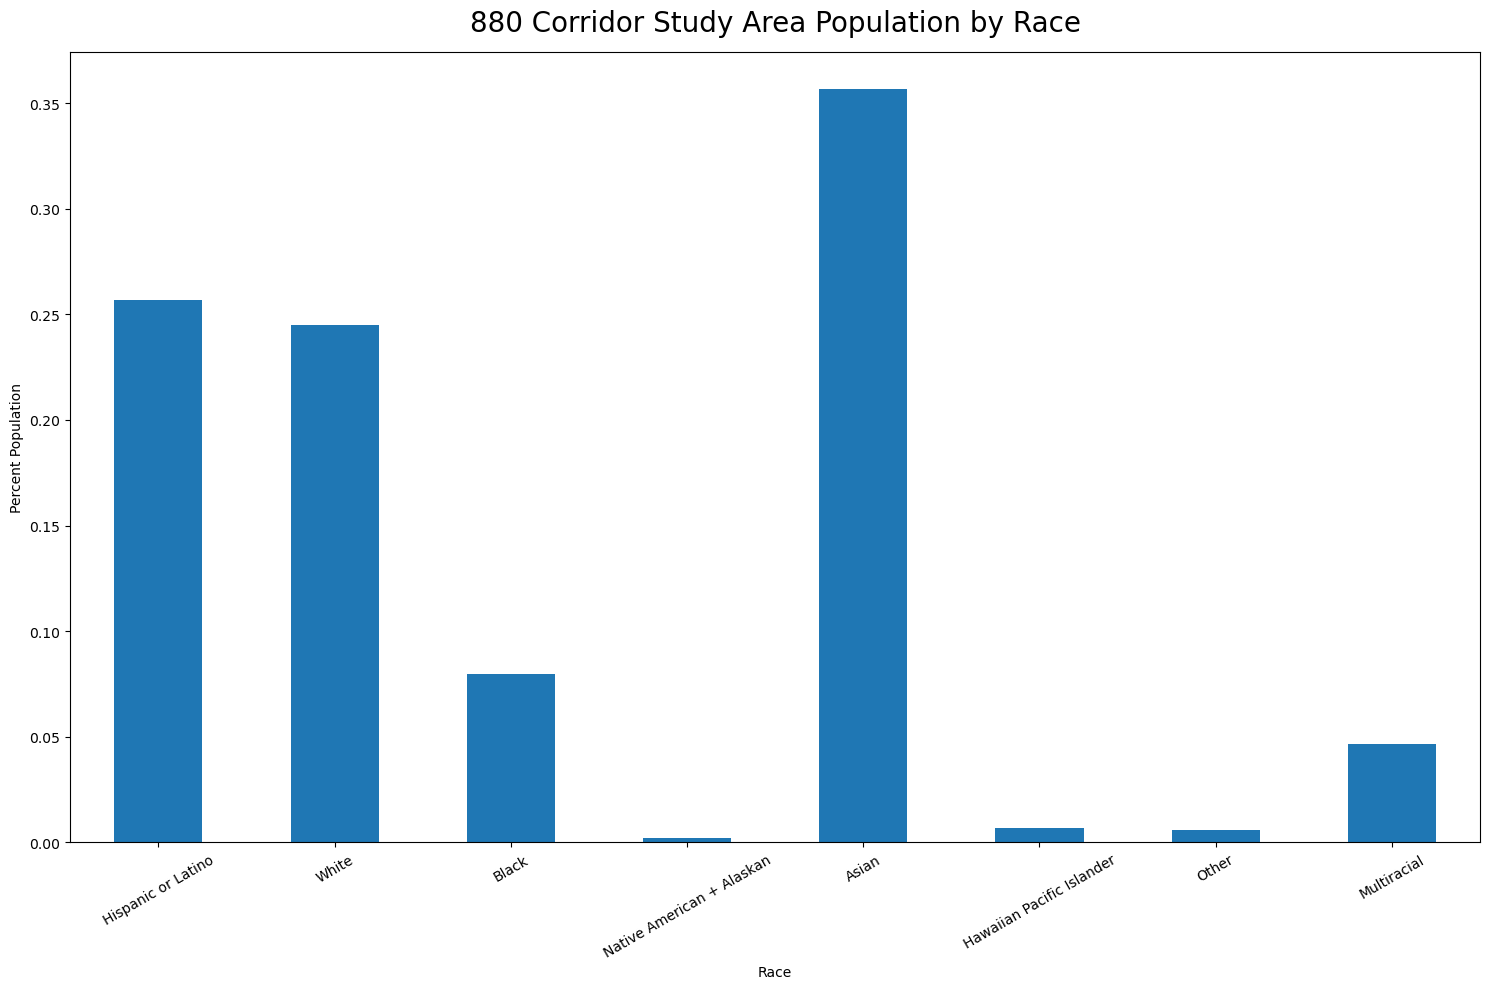

In [61]:
plot_cols = [
    'Hispanic or Latino', 
    'White Alone', 
    'Black Alone',
    'Indian or Alaska Native Alone', 
    'Asian Alone',
    'Hawaiian or Pacific Islander', 
    'Other Race Alone', 
    'Multi Racial'
]
study_area_pct.plot(kind='bar',figsize=(15,10),rot=30,legend=False)

plt.title("880 Corridor Study Area Population by Race",
          fontdict={'fontsize':20},
          pad=15)
plt.xlabel("Race")
plt.ylabel("Percent Population")
plt.ticklabel_format(style='plain',axis='y')
plt.tight_layout()
out_dir = os.path.join(work_dir, 'data','I880_Corridor_Population_by_Race_Origin_Summary_Chart.png')
plt.savefig(out_dir, facecolor='white', dpi=350);